In [3]:
import os
import cv2
from PIL import Image
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pingouin as pg
import scipy
import sklearn.cluster
import colour

In [4]:
rcParams['font.family']='Times New Roman'

In [5]:
def HSV2cone(points):
    points = points.copy().astype(np.double)
    points[:,0] = 2 * np.deg2rad(points[:,0])
    points[:,1] /=255; points[:,2] /= 255    # uniformization
    
    new_points = np.zeros(points.shape, dtype=np.double)
    points_sv = points[:, 1] * points[:, 2]
    
    new_points[:,0] = points_sv * np.cos(points[:, 0])
    new_points[:,1] = points_sv * np.sin(points[:, 0])
    new_points[:,2] = points[:, 2]
    return new_points
    
def cone2HSV(points):
    new_points = np.zeros(points.shape, dtype=np.double)
    new_points[:,0] = np.rad2deg(np.mod(np.arctan2(points[:,1], points[:,0]),2*np.pi))/2
    new_points[:,1] = np.sqrt((np.square(points[:,0])+np.square(points[:,1]))/np.square(points[:,2])) * 255
    new_points[:,2] = points[:,2] * 255
    
    return new_points.astype(np.uint8)

d:\ProgramData\Anaconda3\envs\torch\lib\site-packages\outdated\utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


CCT:
6786.03819223 K
Centers (Cone):


array([[ 0.63273249,  0.06160084,  0.82173422],
       [-0.20009869,  0.16817176,  0.70501046],
       [ 0.08765878,  0.03867493,  0.71794959],
       [ 0.41118389,  0.40982822,  0.80651491],
       [ 0.1128054 , -0.00319234,  0.39561765],
       [-0.2166794 , -0.16189259,  0.48354987]])

Centers (HSV):


array([[  2, 197, 209],
       [ 69,  94, 179],
       [ 11,  34, 183],
       [ 22, 183, 205],
       [179,  72, 100],
       [108, 142, 123]], dtype=uint8)

Percentage:


array([ 20.6947371 ,  26.59375751,  16.58493267,  11.14982511,
        11.71840139,  13.25834622])

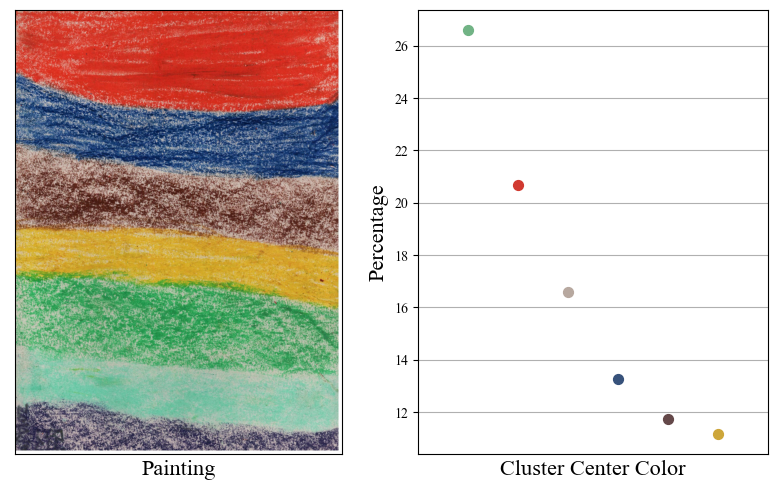

In [92]:
n_clusters = 6

im = cv2.imread("../paintings/experiment/ASD/62.jpg")
im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

im_min = np.minimum(im2[:,:,0],np.minimum(im2[:,:,1],im2[:,:,2]))

ret,im_bin = cv2.threshold(im_min,160,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
im_closed = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, kernel,iterations=2)

draw_pix = np.array(np.where(im_closed == 0)).T
bd_rect = cv2.boundingRect(draw_pix)
        
x1 = bd_rect[1]; x2 = x1+bd_rect[3]
y1 = bd_rect[0]; y2 = y1+bd_rect[2]

pixel_set_hsv = im3[y1:y2+1, x1:x2+1, :].copy()
pixel_set_hsv = pixel_set_hsv.reshape((pixel_set_hsv.shape[0]*pixel_set_hsv.shape[1],3))

# Cone transformation
pixel_set_cone = HSV2cone(pixel_set_hsv)

kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init = 'auto')
kmeans.fit(pixel_set_cone)

histo = np.histogram(kmeans.labels_, bins=n_clusters, range=(0, n_clusters))
percent = histo[0] / pixel_set_cone.shape[0] * 100
tone_idx = percent.argmax()

centers_HSV = cone2HSV(kmeans.cluster_centers_)
center_rgb = cv2.cvtColor(centers_HSV.copy().reshape((1,-1,3)), cv2.COLOR_HSV2RGB)

# Assuming sRGB encoded colour values.
RGB = center_rgb[0,tone_idx,:]
# Conversion to tristimulus values.
XYZ = colour.sRGB_to_XYZ(RGB / 255)
# Conversion to chromaticity coordinates.
xy = colour.XYZ_to_xy(XYZ)
# Conversion to correlated colour temperature in K.
CCT = colour.xy_to_CCT(xy, 'hernandez1999')
print('CCT:')
print(CCT,'K')

print('Centers (Cone):')
display(kmeans.cluster_centers_)
print('Centers (HSV):')
display(centers_HSV)
print('Percentage:')
display(percent)

fig = plt.figure(figsize = (8,5))

plt.subplot(121)
plt.imshow(im2)
plt.xticks([])
plt.yticks([])
plt.xlabel('Painting',fontsize=16)

center_rgb = center_rgb[0,:,:]
center_rgb = np.hstack((percent.reshape(-1,1),center_rgb))
center_rgb = center_rgb[center_rgb[:,0].argsort()[::-1]] # sort by column 1

plt.subplot(122)
for i in range(n_clusters):
    plt.scatter(i, center_rgb[i][0], color=(center_rgb[i][1]/255,center_rgb[i][2]/255,center_rgb[i][3]/255),s=50)
plt.xlim((-1, n_clusters))
plt.ylabel('Percentage',fontsize=16)
plt.xlabel('Cluster Center Color',fontsize=16)
plt.xticks([])
plt.grid()
plt.tight_layout()

fig.savefig('cluster.svg')

In [72]:
draw_classes = ['ASD', 'TD']
draw_num = [379, 162]

In [45]:
CCTs = [[],[]]

n_clusters = 6
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

for i,cls in enumerate(draw_classes):
    print(cls)
    draw_dr = f'../paintings/experiment/{cls}/'
    for j in range(1,draw_num[i]+1):
        print(j)
        im = cv2.imread(f"{draw_dr}/{j}.jpg")
        im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im3 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

        im_min = np.minimum(im2[:,:,0],np.minimum(im2[:,:,1],im2[:,:,2]))

        ret,im_bin = cv2.threshold(im_min,160,255,cv2.THRESH_BINARY)

        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
        im_closed = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, kernel,iterations=2)

        draw_pix = np.array(np.where(im_closed == 0)).T
        bd_rect = cv2.boundingRect(draw_pix)

        x1 = bd_rect[1]; x2 = x1+bd_rect[3]
        y1 = bd_rect[0]; y2 = y1+bd_rect[2]

        pixel_set_hsv = im3[y1:y2+1, x1:x2+1, :].copy()
        pixel_set_hsv = pixel_set_hsv.reshape((pixel_set_hsv.shape[0]*pixel_set_hsv.shape[1],3))

        # Cone transformation
        pixel_set_cone = HSV2cone(pixel_set_hsv)

        kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init = 'auto')
        kmeans.fit(pixel_set_cone)

        histo = np.histogram(kmeans.labels_, bins=n_clusters, range=(0, n_clusters))
        percent = histo[0] / pixel_set_cone.shape[0] * 100
        tone_idx = percent.argmax()

        centers_HSV = cone2HSV(kmeans.cluster_centers_)
        center_rgb = cv2.cvtColor(centers_HSV.copy().reshape((1,-1,3)), cv2.COLOR_HSV2RGB)

        # Assuming sRGB encoded colour values.
        RGB = center_rgb[0,tone_idx,:]
        uv = colour.UCS_to_uv(colour.XYZ_to_UCS(colour.sRGB_to_XYZ(RGB/255)))
        # Conversion to correlated colour temperature in K.
        CCT = colour.uv_to_CCT(uv, 'ohno2013')[0]
        CCTs[i].append(CCT)

ASD
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [46]:
CCTs = np.array(CCTs, dtype=object)
np.save('./results/CCTs.npy', CCTs)

In [47]:
CCTs = np.load('./results/CCTs.npy', allow_pickle=True)

In [48]:
print('Rank-Biserial Correlation')
display(pg.mwu(CCTs[1], CCTs[0]))

Rank-Biserial Correlation


,U-val,alternative,p-val,RBC,CLES
MWU,28978.5,two-sided,0.28055,0.058528,0.470736


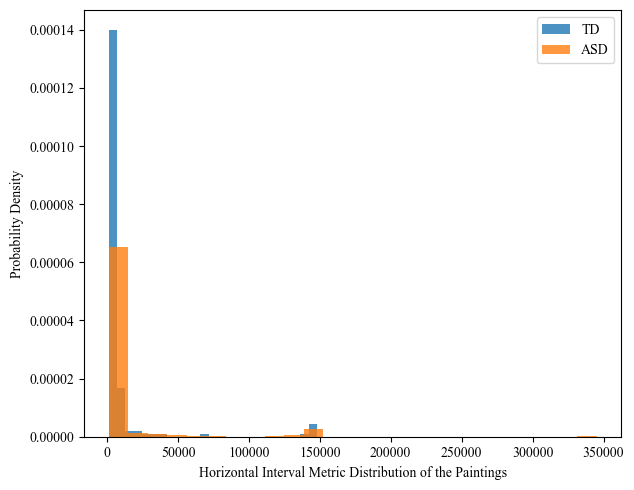

In [51]:
fig = plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(CCTs[1], bins=25, density=True, alpha = 0.8, label='TD')
plt.hist(CCTs[0], bins=25, density=True, alpha = 0.8, label='ASD')

#plt.axvline(np.median(horizon_intervals[1]), linestyle='--', c='#1f77b4', label='Median of TD')
#plt.text(np.median(horizon_intervals[1])+0.0001, 320, np.round(np.median(horizon_intervals[1]),4), c='#1f77b4',fontsize=11)
#plt.axvline(np.median(horizon_intervals[0]), linestyle='--', c='#ff7f0e', label='Median of ASD')
#plt.text(np.median(horizon_intervals[0])+0.0001, 320, np.round(np.median(horizon_intervals[0]),4), c='#ff7f0e',fontsize=11)

plt.ylabel('Probability Density')
plt.xlabel('Horizontal Interval Metric Distribution of the Paintings')
plt.legend()

plt.tight_layout()
plt.show()
#fig.savefig('interval.svg')

In [3]:
draw_classes = ['ASD', 'TD']
draw_num = [379, 162]

In [63]:
tone_HSVs = [[],[]]

n_clusters = 6
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

for i,cls in enumerate(draw_classes):
    print(cls)
    draw_dr = f'../paintings/experiment/{cls}/'
    for j in range(1,draw_num[i]+1):
        print(j)
        im = cv2.imread(f"{draw_dr}/{j}.jpg")
        im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im3 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

        im_min = np.minimum(im2[:,:,0],np.minimum(im2[:,:,1],im2[:,:,2]))

        ret,im_bin = cv2.threshold(im_min,160,255,cv2.THRESH_BINARY)

        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
        im_closed = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, kernel,iterations=2)

        draw_pix = np.array(np.where(im_closed == 0)).T
        bd_rect = cv2.boundingRect(draw_pix)

        x1 = bd_rect[1]; x2 = x1+bd_rect[3]
        y1 = bd_rect[0]; y2 = y1+bd_rect[2]

        pixel_set_hsv = im3[y1:y2+1, x1:x2+1, :].copy()
        pixel_set_hsv = pixel_set_hsv.reshape((pixel_set_hsv.shape[0]*pixel_set_hsv.shape[1],3))

        # Cone transformation
        pixel_set_cone = HSV2cone(pixel_set_hsv)

        kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init = 'auto')
        kmeans.fit(pixel_set_cone)

        histo = np.histogram(kmeans.labels_, bins=n_clusters, range=(0, n_clusters))
        percent = histo[0] / pixel_set_cone.shape[0] * 100
        tone_idx = percent.argmax()

        centers_HSV = cone2HSV(kmeans.cluster_centers_)
        tone_HSV = centers_HSV[tone_idx]
        
        tone_HSVs[i].append(tone_HSV)

ASD
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [74]:
tone_HSVs = np.array(tone_HSVs, dtype=object)
np.save('./results/tone_HSVs.npy', tone_HSVs)

In [7]:
tone_HSVs = np.load('./results/tone_HSVs.npy', allow_pickle=True)
tone_HSVs[0] = [v for i, v in enumerate(tone_HSVs[0]) if i+1 not in {177,205,257,302}]
tone_HSVs[1] = [v for i, v in enumerate(tone_HSVs[1]) if i+1 not in {78,79}]

In [8]:
warm_cold = [[0,0,0,0],[0,0,0,0]]
for i in range(2):
    for tone_HSV in tone_HSVs[i]:
        if tone_HSV[2] < 15:
            warm_cold[i][3] += 1
        elif tone_HSV[1] < 10:
            warm_cold[i][2] += 1
        else:
            warm_dis = np.mod(tone_HSV[0],180)
            cold_dis = np.mod(tone_HSV[0]-90,180)
            if warm_dis < cold_dis:
                warm_cold[i][0] += 1
            else:
                warm_cold[i][1] += 1

In [9]:
print('Contingency Table:')
display(warm_cold)
chi2 = scipy.stats.chi2_contingency(warm_cold)
print(warm_cold[0][1]/np.sum(warm_cold[0]), warm_cold[1][1]/np.sum(warm_cold[1]))
print(f'X2 = {chi2[0]}, p = {chi2[1]}')

Contingency Table:


[[125, 199, 50, 1], [88, 41, 31, 0]]

0.530666666667 0.25625
X2 = 35.18041287475366, p = 1.1158808608468139e-07


In [6]:
def min_distance(points):
    return np.min(scipy.spatial.distance.pdist(points))

In [5]:
draw_classes = ['ASD', 'TD']
draw_num = [379, 162]

In [45]:
color_clusters = [[],[]]

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

for i,cls in enumerate(draw_classes):
    print(cls)
    draw_dr = f'../paintings/experiment/{cls}/'
    for j in range(1,draw_num[i]+1):
        print(j)
        im = cv2.imread(f"{draw_dr}/{j}.jpg")
        im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im3 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

        im_min = np.minimum(im2[:,:,0],np.minimum(im2[:,:,1],im2[:,:,2]))

        ret,im_bin = cv2.threshold(im_min,160,255,cv2.THRESH_BINARY)

        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
        im_closed = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, kernel,iterations=2)

        draw_pix = np.array(np.where(im_closed == 0)).T
        bd_rect = cv2.boundingRect(draw_pix)

        x1 = bd_rect[1]; x2 = x1+bd_rect[3]
        y1 = bd_rect[0]; y2 = y1+bd_rect[2]

        pixel_set_hsv = im3[y1:y2+1, x1:x2+1, :].copy()
        pixel_set_hsv = pixel_set_hsv.reshape((pixel_set_hsv.shape[0]*pixel_set_hsv.shape[1],3))

        # Cone transformation
        pixel_set_cone = HSV2cone(pixel_set_hsv)

        n_clusters = 2
        while True:
            kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init = 'auto')
            kmeans.fit(pixel_set_cone)
            min_dis = min_distance(kmeans.cluster_centers_)
            if min_dis < 0.28:
                n_clusters -= 1
                break
            n_clusters += 1
        color_clusters[i].append(n_clusters)

ASD
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [46]:
color_clusters = np.array(color_clusters, dtype=object)
np.save('./results/color_clusters.npy', color_clusters)

In [11]:
color_clusters = np.load('./results/color_clusters.npy', allow_pickle=True)
color_clusters[0] = [v for i, v in enumerate(color_clusters[0]) if i+1 not in {177,205,257,302}]
color_clusters[1] = [v for i, v in enumerate(color_clusters[1]) if i+1 not in {78,79}]

In [12]:
entropy_hue = np.load('./results/entropy_hue.npy', allow_pickle=True)
entropy_hue[0] = [v for i, v in enumerate(entropy_hue[0]) if i+1 not in {177,205,257,302}]
entropy_hue[1] = [v for i, v in enumerate(entropy_hue[1]) if i+1 not in {78,79}]

In [13]:
print('Rank-Biserial Correlation')
print('Clusters:')
display(pg.mwu(color_clusters[1], color_clusters[0]))
print('Hue Entropy:')
display(pg.mwu(entropy_hue[1], entropy_hue[0]))

Rank-Biserial Correlation
Clusters:


,U-val,alternative,p-val,RBC,CLES
MWU,42852.5,two-sided,1.984333e-15,-0.428417,0.714208


Hue Entropy:


,U-val,alternative,p-val,RBC,CLES
MWU,36588.0,two-sided,0.000057,-0.2196,0.6098


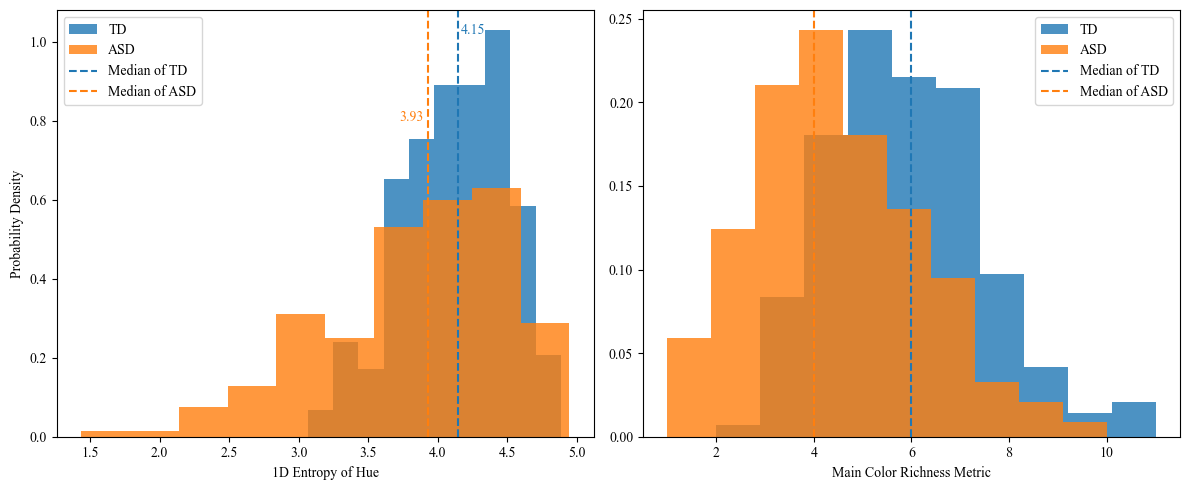

In [18]:
fig = plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(entropy_hue[1], bins=10, density=True, alpha = 0.8, label='TD')
plt.hist(entropy_hue[0], bins=10, density=True, alpha = 0.8, label='ASD')

plt.axvline(np.median(entropy_hue[1]), linestyle='--', c='#1f77b4', label='Median of TD')
plt.text(np.median(entropy_hue[1])+0.02, 1.02, np.round(np.median(entropy_hue[1]),2), c='#1f77b4')
plt.axvline(np.median(entropy_hue[0]), linestyle='--', c='#ff7f0e', label='Median of ASD')
plt.text(np.median(entropy_hue[0])-0.2, 0.8, np.round(np.median(entropy_hue[0]),2), c='#ff7f0e')

plt.ylabel('Probability Density')
plt.xlabel('1D Entropy of Hue')
plt.legend()

plt.subplot(122)

plt.hist(color_clusters[1], bins=10, density=True, alpha = 0.8, label='TD')
plt.hist(color_clusters[0], bins=10, density=True, alpha = 0.8, label='ASD')

plt.axvline(np.median(color_clusters[1]), linestyle='--', c='#1f77b4', label='Median of TD')
#plt.text(np.median(color_clusters[1])+0.2, 0.23, int(np.median(color_clusters[1])), c='#1f77b4')
plt.axvline(np.median(color_clusters[0]), linestyle='--', c='#ff7f0e', label='Median of ASD')
#plt.text(np.median(color_clusters[0])-0.5, 0.23, int(np.median(color_clusters[0])), c='#ff7f0e')

plt.xlabel('Main Color Richness Metric')
plt.legend()

plt.tight_layout()
plt.show()
fig.savefig('color.svg')

In [ ]:
color_richness = [[0,0,0,0,0],[0,0,0,0,0]]   # reverse very rich (>= 9), rich (>=7), moderate (>=5), poor (>=3), very poor (<=2)
richness_map = [0,0,0,1,1,2,2,3,3,4,4,4,4,4,4,4,4,4,4,4,4]

color_richness[i][richness_map[n_clusters]] += 1

In [44]:
print('Contingency Table:')
display(color_richness)
chi2 = scipy.stats.chi2_contingency(color_richness)
print(color_richness[0][1]/np.sum(color_richness[0]), color_richness[0][2]/np.sum(color_richness[0]), color_richness[0][3]/np.sum(color_richness[0]), color_richness[0][4]/np.sum(color_richness[0]))
print(color_richness[1][1]/np.sum(color_richness[1]), color_richness[1][2]/np.sum(color_richness[1]), color_richness[1][3]/np.sum(color_richness[1]), color_richness[1][4]/np.sum(color_richness[1]))
print(f'X2 = {chi2[0]}, p = {chi2[1]}')

Contingency Table:


[[63, 156, 100, 47, 13], [0, 39, 70, 43, 10]]

0.411609498681 0.263852242744 0.12401055409 0.0343007915567
0.240740740741 0.432098765432 0.265432098765 0.0617283950617
X2 = 61.9971634770786, p = 1.1031072369586559e-12


CCT:
6879.94232707 K
Centers (Cone):


array([[ 0.63220879,  0.06159798,  0.82202744],
       [ 0.06185858,  0.03642756,  0.72832338],
       [ 0.41059263,  0.40954835,  0.80712613],
       [ 0.19161092,  0.04106914,  0.43613602],
       [-0.17256118, -0.14330761,  0.45055883],
       [-0.20562998,  0.17213021,  0.70281664]])

Min dist:


0.30102480057073067

Centers (HSV):


array([[  2, 197, 209],
       [ 15,  25, 185],
       [ 22, 183, 205],
       [  6, 114, 111],
       [109, 126, 114],
       [ 70,  97, 179]], dtype=uint8)

Percentage:


array([ 20.71627324,  16.74944333,  11.15768663,   8.81049635,
        17.03262421,  25.53347624])

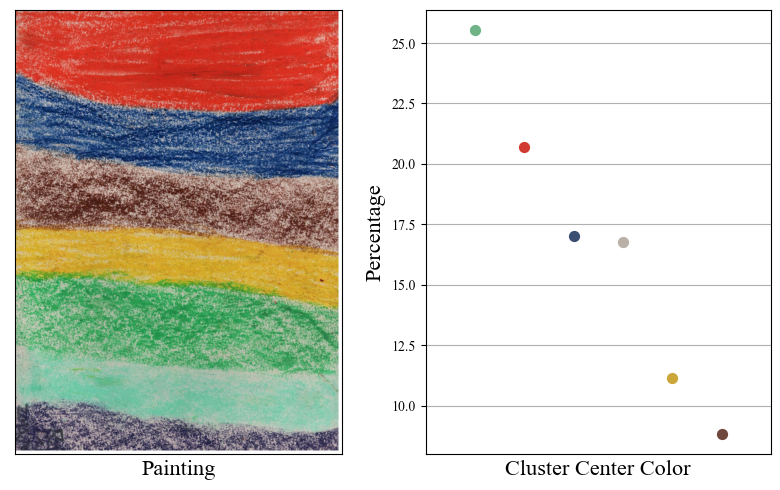

In [10]:
n_clusters = 6

im = cv2.imread("../paintings/experiment/ASD/62.jpg")
im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

im_min = np.minimum(im2[:,:,0],np.minimum(im2[:,:,1],im2[:,:,2]))

ret,im_bin = cv2.threshold(im_min,160,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
im_closed = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, kernel,iterations=2)

draw_pix = np.array(np.where(im_closed == 0)).T
bd_rect = cv2.boundingRect(draw_pix)
        
x1 = bd_rect[1]; x2 = x1+bd_rect[3]
y1 = bd_rect[0]; y2 = y1+bd_rect[2]

pixel_set_hsv = im3[y1:y2+1, x1:x2+1, :].copy()
pixel_set_hsv = pixel_set_hsv.reshape((pixel_set_hsv.shape[0]*pixel_set_hsv.shape[1],3))

# Cone transformation
pixel_set_cone = HSV2cone(pixel_set_hsv)

kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init = 'auto')
kmeans.fit(pixel_set_cone)

histo = np.histogram(kmeans.labels_, bins=n_clusters, range=(0, n_clusters))
percent = histo[0] / pixel_set_cone.shape[0] * 100
tone_idx = percent.argmax()

centers_HSV = cone2HSV(kmeans.cluster_centers_)
center_rgb = cv2.cvtColor(centers_HSV.copy().reshape((1,-1,3)), cv2.COLOR_HSV2RGB)

# Assuming sRGB encoded colour values.
RGB = center_rgb[0,tone_idx,:]
# Conversion to tristimulus values.
XYZ = colour.sRGB_to_XYZ(RGB / 255)
# Conversion to chromaticity coordinates.
xy = colour.XYZ_to_xy(XYZ)
# Conversion to correlated colour temperature in K.
CCT = colour.xy_to_CCT(xy, 'hernandez1999')
print('CCT:')
print(CCT,'K')

print('Centers (Cone):')
display(kmeans.cluster_centers_)
print('Min dist:')
display(min_distance(kmeans.cluster_centers_))
print('Centers (HSV):')
display(centers_HSV)
print('Percentage:')
display(percent)

fig = plt.figure(figsize = (8,5))

plt.subplot(121)
plt.imshow(im2)
plt.xticks([])
plt.yticks([])
plt.xlabel('Painting',fontsize=16)

center_rgb = center_rgb[0,:,:]
center_rgb = np.hstack((percent.reshape(-1,1),center_rgb))
center_rgb = center_rgb[center_rgb[:,0].argsort()[::-1]] # sort by column 1

plt.subplot(122)
for i in range(n_clusters):
    plt.scatter(i, center_rgb[i][0], color=(center_rgb[i][1]/255,center_rgb[i][2]/255,center_rgb[i][3]/255),s=50)
plt.xlim((-1, n_clusters))
plt.ylabel('Percentage',fontsize=16)
plt.xlabel('Cluster Center Color',fontsize=16)
plt.xticks([])
plt.grid()
plt.tight_layout()
fig.savefig('1.svg')

CCT:
5004.90016763 K
Centers (Cone):


array([[ 0.38671579, -0.17728973,  0.73028562],
       [ 0.14455002, -0.02461409,  0.76084331],
       [ 0.02196564,  0.03644587,  0.29450244],
       [ 0.5300949 ,  0.18757545,  0.8341869 ],
       [ 0.24319568,  0.35995512,  0.83816185],
       [-0.40068521,  0.01114949,  0.63662437]])

Min dist:


0.28790255485706023

Centers (HSV):


array([[167, 148, 186],
       [175,  49, 194],
       [ 29,  36,  75],
       [  9, 171, 212],
       [ 27, 132, 213],
       [ 89, 160, 162]], dtype=uint8)

Percentage:


array([  4.01580072,  39.03846849,  23.42893302,   7.22434756,
        21.05796607,   5.23448413])

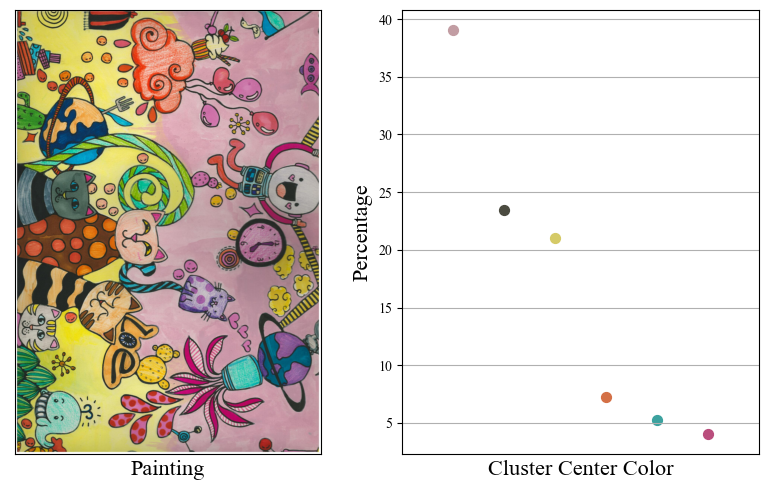

In [11]:
n_clusters = 6

im = cv2.imread("../paintings/experiment/TD/123.jpg")
im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

im_min = np.minimum(im2[:,:,0],np.minimum(im2[:,:,1],im2[:,:,2]))

ret,im_bin = cv2.threshold(im_min,160,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
im_closed = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, kernel,iterations=2)

draw_pix = np.array(np.where(im_closed == 0)).T
bd_rect = cv2.boundingRect(draw_pix)
        
x1 = bd_rect[1]; x2 = x1+bd_rect[3]
y1 = bd_rect[0]; y2 = y1+bd_rect[2]

pixel_set_hsv = im3[y1:y2+1, x1:x2+1, :].copy()
pixel_set_hsv = pixel_set_hsv.reshape((pixel_set_hsv.shape[0]*pixel_set_hsv.shape[1],3))

# Cone transformation
pixel_set_cone = HSV2cone(pixel_set_hsv)

kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init = 'auto')
kmeans.fit(pixel_set_cone)

histo = np.histogram(kmeans.labels_, bins=n_clusters, range=(0, n_clusters))
percent = histo[0] / pixel_set_cone.shape[0] * 100
tone_idx = percent.argmax()

centers_HSV = cone2HSV(kmeans.cluster_centers_)
center_rgb = cv2.cvtColor(centers_HSV.copy().reshape((1,-1,3)), cv2.COLOR_HSV2RGB)

# Assuming sRGB encoded colour values.
RGB = center_rgb[0,tone_idx,:]
# Conversion to tristimulus values.
XYZ = colour.sRGB_to_XYZ(RGB / 255)
# Conversion to chromaticity coordinates.
xy = colour.XYZ_to_xy(XYZ)
# Conversion to correlated colour temperature in K.
CCT = colour.xy_to_CCT(xy, 'hernandez1999')
print('CCT:')
print(CCT,'K')

print('Centers (Cone):')
display(kmeans.cluster_centers_)
print('Min dist:')
display(min_distance(kmeans.cluster_centers_))
print('Centers (HSV):')
display(centers_HSV)
print('Percentage:')
display(percent)

fig = plt.figure(figsize = (8,5))

plt.subplot(121)
plt.imshow(im2)
plt.xticks([])
plt.yticks([])
plt.xlabel('Painting',fontsize=16)

center_rgb = center_rgb[0,:,:]
center_rgb = np.hstack((percent.reshape(-1,1),center_rgb))
center_rgb = center_rgb[center_rgb[:,0].argsort()[::-1]] # sort by column 1

plt.subplot(122)
for i in range(n_clusters):
    plt.scatter(i, center_rgb[i][0], color=(center_rgb[i][1]/255,center_rgb[i][2]/255,center_rgb[i][3]/255),s=50)
plt.xlim((-1, n_clusters))
plt.ylabel('Percentage',fontsize=16)
plt.xlabel('Cluster Center Color',fontsize=16)
plt.xticks([])
plt.grid()
plt.tight_layout()
plt.savefig('1.svg')

CCT:
2878.27641576 K
Centers (Cone):


array([[  3.68625851e-01,  -1.17642668e-01,   8.86935218e-01],
       [ -4.02151938e-01,   3.10248431e-01,   5.47003912e-01],
       [  5.17618389e-01,   6.70023847e-01,   9.25556789e-01],
       [  8.31819066e-04,   4.30735896e-02,   2.48024377e-01],
       [  1.05277345e-01,   8.68200978e-02,   8.23046932e-01],
       [  3.53244920e-01,   2.80391741e-01,   8.72735364e-01]])

Min dist:


0.31847580723403396

Centers (HSV):


array([[171, 111, 226],
       [ 71, 236, 139],
       [ 26, 233, 236],
       [ 44,  44,  63],
       [ 19,  42, 209],
       [ 19, 131, 222]], dtype=uint8)

Percentage:


array([ 25.37348534,  17.60261454,  15.93823067,  18.83062819,
        10.97540369,  11.27963758])

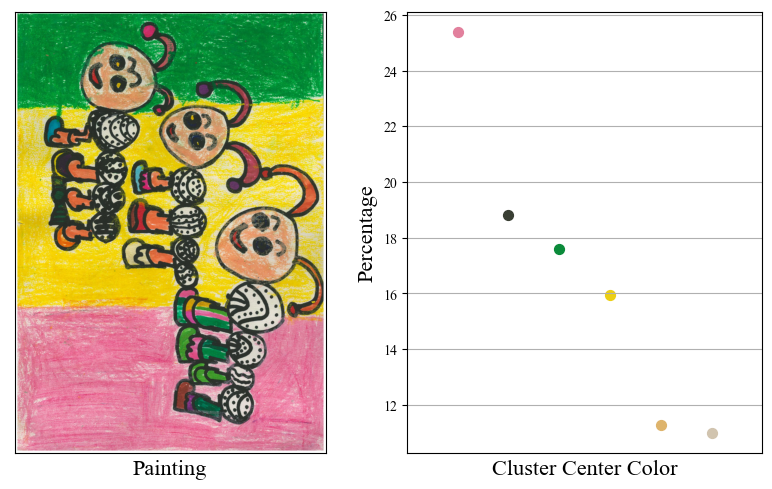

In [7]:
n_clusters = 6

im = cv2.imread("../paintings/experiment/TD/64.jpg")
im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

im_min = np.minimum(im2[:,:,0],np.minimum(im2[:,:,1],im2[:,:,2]))

ret,im_bin = cv2.threshold(im_min,160,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
im_closed = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, kernel,iterations=2)

draw_pix = np.array(np.where(im_closed == 0)).T
bd_rect = cv2.boundingRect(draw_pix)
        
x1 = bd_rect[1]; x2 = x1+bd_rect[3]
y1 = bd_rect[0]; y2 = y1+bd_rect[2]

pixel_set_hsv = im3[y1:y2+1, x1:x2+1, :].copy()
pixel_set_hsv = pixel_set_hsv.reshape((pixel_set_hsv.shape[0]*pixel_set_hsv.shape[1],3))

# Cone transformation
pixel_set_cone = HSV2cone(pixel_set_hsv)

kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init = 'auto')
kmeans.fit(pixel_set_cone)

histo = np.histogram(kmeans.labels_, bins=n_clusters, range=(0, n_clusters))
percent = histo[0] / pixel_set_cone.shape[0] * 100
tone_idx = percent.argmax()

centers_HSV = cone2HSV(kmeans.cluster_centers_)
center_rgb = cv2.cvtColor(centers_HSV.copy().reshape((1,-1,3)), cv2.COLOR_HSV2RGB)

# Assuming sRGB encoded colour values.
RGB = center_rgb[0,tone_idx,:]
# Conversion to tristimulus values.
XYZ = colour.sRGB_to_XYZ(RGB / 255)
# Conversion to chromaticity coordinates.
xy = colour.XYZ_to_xy(XYZ)
# Conversion to correlated colour temperature in K.
CCT = colour.xy_to_CCT(xy, 'hernandez1999')
print('CCT:')
print(CCT,'K')

print('Centers (Cone):')
display(kmeans.cluster_centers_)
print('Min dist:')
display(min_distance(kmeans.cluster_centers_))
print('Centers (HSV):')
display(centers_HSV)
print('Percentage:')
display(percent)

fig = plt.figure(figsize = (8,5))

plt.subplot(121)
plt.imshow(im2)
plt.xticks([])
plt.yticks([])
plt.xlabel('Painting',fontsize=16)

center_rgb = center_rgb[0,:,:]
center_rgb = np.hstack((percent.reshape(-1,1),center_rgb))
center_rgb = center_rgb[center_rgb[:,0].argsort()[::-1]] # sort by column 1

plt.subplot(122)
for i in range(n_clusters):
    plt.scatter(i, center_rgb[i][0], color=(center_rgb[i][1]/255,center_rgb[i][2]/255,center_rgb[i][3]/255),s=50)
plt.xlim((-1, n_clusters))
plt.ylabel('Percentage',fontsize=16)
plt.xlabel('Cluster Center Color',fontsize=16)
plt.xticks([])
plt.grid()
plt.tight_layout()

CCT:
5976.98572097 K
Centers (Cone):


array([[-0.01026458,  0.01635925,  0.20730151],
       [ 0.23613537,  0.28932166,  0.8121968 ],
       [-0.58299236, -0.21853454,  0.66289664],
       [ 0.04480461,  0.0102137 ,  0.77519918],
       [-0.32218985,  0.04531238,  0.52130074],
       [ 0.45912807,  0.05624014,  0.74885439]])

Min dist:


0.32873240888075472

Centers (HSV):


array([[ 61,  23,  52],
       [ 25, 117, 207],
       [100, 239, 169],
       [  6,  15, 197],
       [ 85, 159, 132],
       [  3, 157, 190]], dtype=uint8)

Percentage:


array([ 29.45618428,  13.49064355,   6.22387602,  31.80499193,
        10.95418409,   8.07012014])

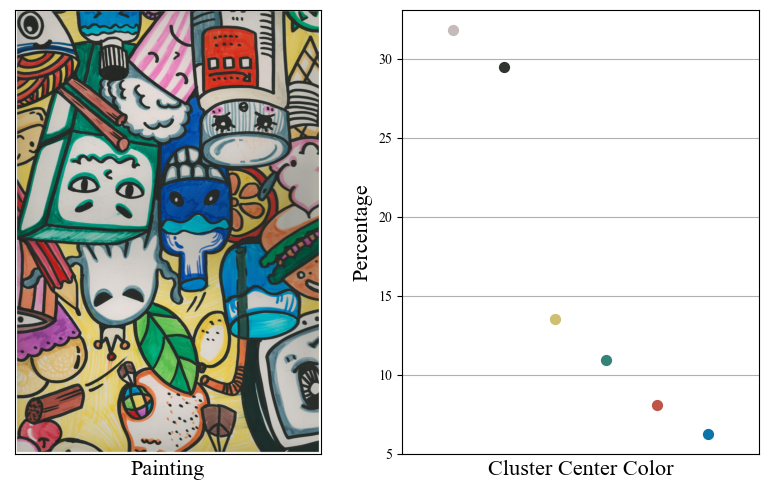

In [13]:
n_clusters = 6

im = cv2.imread("../paintings/experiment/TD/122.jpg")
im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

im_min = np.minimum(im2[:,:,0],np.minimum(im2[:,:,1],im2[:,:,2]))

ret,im_bin = cv2.threshold(im_min,160,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
im_closed = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, kernel,iterations=2)

draw_pix = np.array(np.where(im_closed == 0)).T
bd_rect = cv2.boundingRect(draw_pix)
        
x1 = bd_rect[1]; x2 = x1+bd_rect[3]
y1 = bd_rect[0]; y2 = y1+bd_rect[2]

pixel_set_hsv = im3[y1:y2+1, x1:x2+1, :].copy()
pixel_set_hsv = pixel_set_hsv.reshape((pixel_set_hsv.shape[0]*pixel_set_hsv.shape[1],3))

# Cone transformation
pixel_set_cone = HSV2cone(pixel_set_hsv)

kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init = 'auto')
kmeans.fit(pixel_set_cone)

histo = np.histogram(kmeans.labels_, bins=n_clusters, range=(0, n_clusters))
percent = histo[0] / pixel_set_cone.shape[0] * 100
tone_idx = percent.argmax()

centers_HSV = cone2HSV(kmeans.cluster_centers_)
center_rgb = cv2.cvtColor(centers_HSV.copy().reshape((1,-1,3)), cv2.COLOR_HSV2RGB)

# Assuming sRGB encoded colour values.
RGB = center_rgb[0,tone_idx,:]
# Conversion to tristimulus values.
XYZ = colour.sRGB_to_XYZ(RGB / 255)
# Conversion to chromaticity coordinates.
xy = colour.XYZ_to_xy(XYZ)
# Conversion to correlated colour temperature in K.
CCT = colour.xy_to_CCT(xy, 'hernandez1999')
print('CCT:')
print(CCT,'K')

print('Centers (Cone):')
display(kmeans.cluster_centers_)
print('Min dist:')
display(min_distance(kmeans.cluster_centers_))
print('Centers (HSV):')
display(centers_HSV)
print('Percentage:')
display(percent)

fig = plt.figure(figsize = (8,5))

plt.subplot(121)
plt.imshow(im2)
plt.xticks([])
plt.yticks([])
plt.xlabel('Painting',fontsize=16)

center_rgb = center_rgb[0,:,:]
center_rgb = np.hstack((percent.reshape(-1,1),center_rgb))
center_rgb = center_rgb[center_rgb[:,0].argsort()[::-1]] # sort by column 1

plt.subplot(122)
for i in range(n_clusters):
    plt.scatter(i, center_rgb[i][0], color=(center_rgb[i][1]/255,center_rgb[i][2]/255,center_rgb[i][3]/255),s=50)
plt.xlim((-1, n_clusters))
plt.ylabel('Percentage',fontsize=16)
plt.xlabel('Cluster Center Color',fontsize=16)
plt.xticks([])
plt.grid()
plt.tight_layout()

CCT:
464.863295963 K
Centers (Cone):


array([[ 0.55120969, -0.15590378,  0.79027957],
       [-0.22053799,  0.14255781,  0.51373005],
       [-0.05313989, -0.18718458,  0.33286263],
       [ 0.17815564,  0.01875269,  0.34992458],
       [-0.4292815 , -0.27522629,  0.68486236],
       [ 0.28414016,  0.14089129,  0.80338266]])

Min dist:


0.31015946302595965

Centers (HSV):


array([[172, 184, 201],
       [ 73, 130, 131],
       [127, 149,  84],
       [  3, 130,  89],
       [106, 189, 174],
       [ 13, 100, 204]], dtype=uint8)

Percentage:


array([ 25.80991513,  14.60360133,  20.11753491,  14.78846   ,
        10.20868444,  14.47180419])

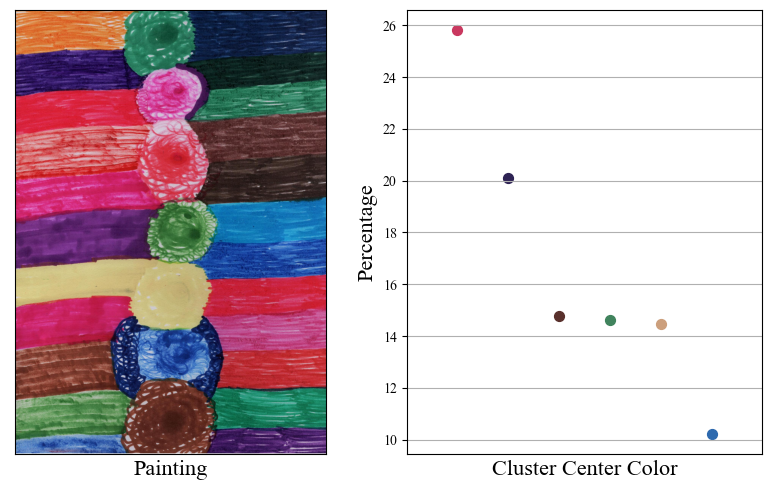

In [10]:
n_clusters = 6

im = cv2.imread("../paintings/experiment/ASD/41.jpg")
im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

im_min = np.minimum(im2[:,:,0],np.minimum(im2[:,:,1],im2[:,:,2]))

ret,im_bin = cv2.threshold(im_min,160,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
im_closed = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, kernel,iterations=2)

draw_pix = np.array(np.where(im_closed == 0)).T
bd_rect = cv2.boundingRect(draw_pix)
        
x1 = bd_rect[1]; x2 = x1+bd_rect[3]
y1 = bd_rect[0]; y2 = y1+bd_rect[2]

pixel_set_hsv = im3[y1:y2+1, x1:x2+1, :].copy()
pixel_set_hsv = pixel_set_hsv.reshape((pixel_set_hsv.shape[0]*pixel_set_hsv.shape[1],3))

# Cone transformation
pixel_set_cone = HSV2cone(pixel_set_hsv)

kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init = 'auto')
kmeans.fit(pixel_set_cone)

histo = np.histogram(kmeans.labels_, bins=n_clusters, range=(0, n_clusters))
percent = histo[0] / pixel_set_cone.shape[0] * 100
tone_idx = percent.argmax()

centers_HSV = cone2HSV(kmeans.cluster_centers_)
center_rgb = cv2.cvtColor(centers_HSV.copy().reshape((1,-1,3)), cv2.COLOR_HSV2RGB)

# Assuming sRGB encoded colour values.
RGB = center_rgb[0,tone_idx,:]
# Conversion to tristimulus values.
XYZ = colour.sRGB_to_XYZ(RGB / 255)
# Conversion to chromaticity coordinates.
xy = colour.XYZ_to_xy(XYZ)
# Conversion to correlated colour temperature in K.
CCT = colour.xy_to_CCT(xy, 'hernandez1999')
print('CCT:')
print(CCT,'K')

print('Centers (Cone):')
display(kmeans.cluster_centers_)
print('Min dist:')
display(min_distance(kmeans.cluster_centers_))
print('Centers (HSV):')
display(centers_HSV)
print('Percentage:')
display(percent)

fig = plt.figure(figsize = (8,5))

plt.subplot(121)
plt.imshow(im2)
plt.xticks([])
plt.yticks([])
plt.xlabel('Painting',fontsize=16)

center_rgb = center_rgb[0,:,:]
center_rgb = np.hstack((percent.reshape(-1,1),center_rgb))
center_rgb = center_rgb[center_rgb[:,0].argsort()[::-1]] # sort by column 1

plt.subplot(122)
for i in range(n_clusters):
    plt.scatter(i, center_rgb[i][0], color=(center_rgb[i][1]/255,center_rgb[i][2]/255,center_rgb[i][3]/255),s=50)
plt.xlim((-1, n_clusters))
plt.ylabel('Percentage',fontsize=16)
plt.xlabel('Cluster Center Color',fontsize=16)
plt.xticks([])
plt.grid()
plt.tight_layout()

CCT:
10556.8946004 K
Centers (Cone):


array([[-0.09136267,  0.05814048,  0.72914317],
       [-0.50431832, -0.14719514,  0.81194322],
       [-0.28954273, -0.0328671 ,  0.77897818],
       [ 0.54929072, -0.07690081,  0.77830176],
       [-0.04980215,  0.32476966,  0.67529878],
       [ 0.21304201,  0.0844224 ,  0.65779547]])

Min dist:


0.22369899923332251

Centers (HSV):


array([[ 73,  37, 185],
       [ 98, 164, 207],
       [ 93,  95, 198],
       [176, 181, 198],
       [ 49, 124, 172],
       [ 10,  88, 167]], dtype=uint8)

Percentage:


array([ 23.47528289,  21.7722389 ,  23.87606687,   1.75460776,
        19.15785109,   9.96395248])

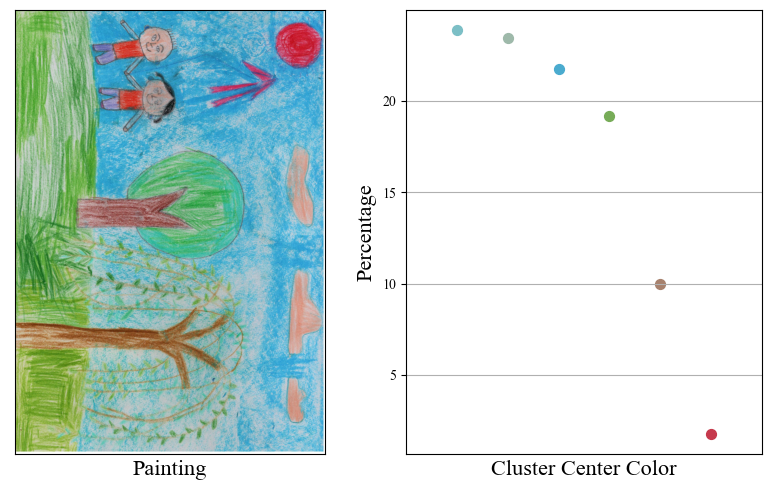

In [23]:
n_clusters = 6

im = cv2.imread("../paintings/experiment/ASD/36.jpg")
im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

im_min = np.minimum(im2[:,:,0],np.minimum(im2[:,:,1],im2[:,:,2]))

ret,im_bin = cv2.threshold(im_min,160,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
im_closed = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, kernel,iterations=2)

draw_pix = np.array(np.where(im_closed == 0)).T
bd_rect = cv2.boundingRect(draw_pix)
        
x1 = bd_rect[1]; x2 = x1+bd_rect[3]
y1 = bd_rect[0]; y2 = y1+bd_rect[2]

pixel_set_hsv = im3[y1:y2+1, x1:x2+1, :].copy()
pixel_set_hsv = pixel_set_hsv.reshape((pixel_set_hsv.shape[0]*pixel_set_hsv.shape[1],3))

# Cone transformation
pixel_set_cone = HSV2cone(pixel_set_hsv)

kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init = 'auto')
kmeans.fit(pixel_set_cone)

histo = np.histogram(kmeans.labels_, bins=n_clusters, range=(0, n_clusters))
percent = histo[0] / pixel_set_cone.shape[0] * 100
tone_idx = percent.argmax()

centers_HSV = cone2HSV(kmeans.cluster_centers_)
center_rgb = cv2.cvtColor(centers_HSV.copy().reshape((1,-1,3)), cv2.COLOR_HSV2RGB)

# Assuming sRGB encoded colour values.
RGB = center_rgb[0,tone_idx,:]
# Conversion to tristimulus values.
XYZ = colour.sRGB_to_XYZ(RGB / 255)
# Conversion to chromaticity coordinates.
xy = colour.XYZ_to_xy(XYZ)
# Conversion to correlated colour temperature in K.
CCT = colour.xy_to_CCT(xy, 'hernandez1999')
print('CCT:')
print(CCT,'K')

print('Centers (Cone):')
display(kmeans.cluster_centers_)
print('Min dist:')
display(min_distance(kmeans.cluster_centers_))
print('Centers (HSV):')
display(centers_HSV)
print('Percentage:')
display(percent)

fig = plt.figure(figsize = (8,5))

plt.subplot(121)
plt.imshow(im2)
plt.xticks([])
plt.yticks([])
plt.xlabel('Painting',fontsize=16)

center_rgb = center_rgb[0,:,:]
center_rgb = np.hstack((percent.reshape(-1,1),center_rgb))
center_rgb = center_rgb[center_rgb[:,0].argsort()[::-1]] # sort by column 1

plt.subplot(122)
for i in range(n_clusters):
    plt.scatter(i, center_rgb[i][0], color=(center_rgb[i][1]/255,center_rgb[i][2]/255,center_rgb[i][3]/255),s=50)
plt.xlim((-1, n_clusters))
plt.ylabel('Percentage',fontsize=16)
plt.xlabel('Cluster Center Color',fontsize=16)
plt.xticks([])
plt.grid()
plt.tight_layout()